### **Abstract**

In this blog post, we will walk through the process of training a linear regression model, creating a scoring function, and finding an optimal threshold for a scoring and classification problem. The dataset we are working with is one with data about prospective loan borrowers from a bank. It includes various characteristics of each person and the loan they are requesting. We will use this data to determine a threshold and scoring function to determine whether or not, if given the loan, the borrower is likely to default (or, in laymans terms, violate the terms of the loan by not paying/causing the bank to lose money). We will use the scikit-learn library again for this blog post. First, we will train a logistic regression model. Then we will find optimal values for the weight vector and the threshold so that we can determine the optimal profit/borrower.

### **Part A: Grab the Data**

To begin, let's import the data:

In [276]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

We can take a look at the columns so that we know what attributes we are working with.

In [277]:
df_train.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

### **Part B: Explore The Data**

Now, we can make a few figures to explore what the data is saying. First, I created a scatterplot to show the relationship between a person's age and their credit history length. As can be inferred, older people generally have longer credit histories.

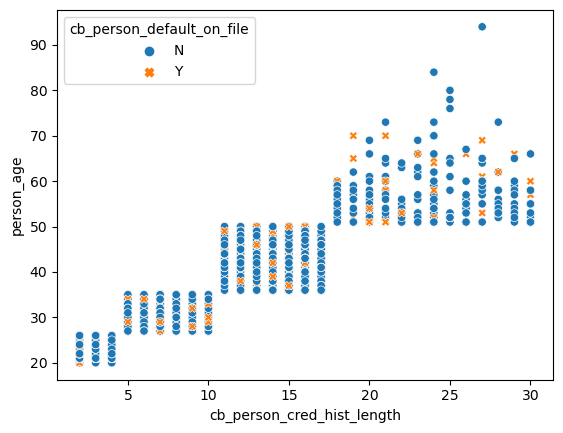

In [278]:
fig, ax = plt.subplots(1, 1)
# cut out the huge outlier--person making 6m/yr--so that we can see patterns more clearly
p1 = sns.scatterplot(df_train[df_train["person_age"] < 100], x = "cb_person_cred_hist_length", y = 'person_age', hue = 'cb_person_default_on_file', style = 'cb_person_default_on_file')


However, I was very interested in the fact that whether or not people defaulted on their loan seemed not to be reliant on age. There are orange x's in all parts of the plot. Because of this, I wanted to look at the mean age for people who had a history of defaulting and people who didn't.

In [279]:
df_train.groupby("cb_person_default_on_file")["person_age"].mean()

cb_person_default_on_file
N    27.721878
Y    27.793096
Name: person_age, dtype: float64

As you can see, although the average age for people who had defaulted was slightly bigger, they still both had averages of about 27. This was surprising to me because I had previously assumed that people who are older, and therefore have longer credit histories, would be more likely to have defaulted on a loan. I wonder if this is due to financial differences between generations.

Next, I wanted to look at interest rate based on history of defaulting. I assumed before making the plot that people who had defaulted before would be given a higher interest rate, and I was correct.

Text(0.5, 1.0, 'Average loan interest rate separated by previous loan defaults')

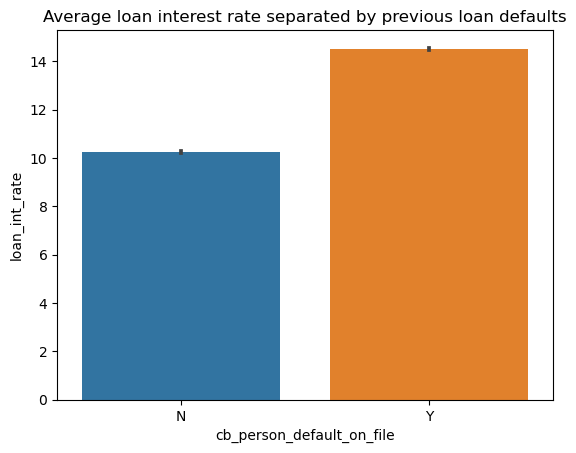

In [280]:
barplot = sns.barplot(df_train, x = "cb_person_default_on_file", y = "loan_int_rate")
barplot.set_title("Average loan interest rate separated by previous loan defaults")

Here, we can see that the average loan interest rate for those who had not defaulted on a loan previously is about 10%. For those who had, it was about 15%. A 5% increase is quite significant, and it seems like having a clean loan history would significantly benefit someone's chances at getting a good interest rate.

Next, I wanted to look at the factors which played into loan intent. To do this, I created a table showing the home ownership counts per loan intent.

In [281]:
df_train.groupby("loan_intent")["person_home_ownership"].value_counts()

loan_intent        person_home_ownership
DEBTCONSOLIDATION  RENT                     2260
                   MORTGAGE                 1841
                   OWN                        62
                   OTHER                      15
EDUCATION          RENT                     2612
                   MORTGAGE                 2089
                   OWN                       412
                   OTHER                      14
HOMEIMPROVEMENT    MORTGAGE                 1384
                   RENT                     1252
                   OWN                       255
                   OTHER                      11
MEDICAL            RENT                     2740
                   MORTGAGE                 1730
                   OWN                       352
                   OTHER                      13
PERSONAL           RENT                     2171
                   MORTGAGE                 1868
                   OWN                       354
                   OTHER    

We can see here that there isn't too much variation, but there are definitely differences that stand out. By far, the most popular type of loan for homeowners is a venture loan, and very few homeowners requested a debt consolidation loan. People with mortgages were spread out pretty evenly across the board, but home improvement had the least mortgagers. By far, home improvement was the least popular type of loan amongst renters. All of these make sense to me for a few reasons. Homeowners gravitated towards venture loans because, in general, they are likely to be more financially stable. Renters did not go for the home improvement loans because they likely don't have much say in what gets done on the property they are renting. There are so few people in the "other" category that it is hard to pick out trends.

Next, we are going to prepare the data the same way that we did last time. We will split into x and y, removing the target variables from the training set. We will also get rid of null variables.

In [282]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train["loan_status"])

def prepare_data(df):
  df = df.dropna()
  y = le.transform(df["loan_status"])
  df = df.drop(["loan_status"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

x_train, y_train = prepare_data(df_train)
x_train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,13.47,0.12,6,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,22,36996,5.0,10000,7.51,0.27,4,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,24,26000,2.0,1325,12.87,0.05,4,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,29,53004,2.0,15000,9.63,0.28,10,True,False,False,...,False,True,False,False,False,False,False,False,True,False
6,21,21700,2.0,5500,14.91,0.25,2,False,False,False,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,8.0,3000,7.29,0.02,17,True,False,False,...,False,True,False,False,False,False,False,False,True,False
26060,23,48000,1.0,4325,5.42,0.09,4,False,False,False,...,True,True,False,False,False,False,False,False,True,False
26061,22,60000,0.0,15000,11.71,0.25,4,False,False,False,...,False,False,True,False,False,False,False,False,True,False
26062,30,144000,12.0,35000,12.68,0.24,8,True,False,False,...,False,False,False,True,False,False,False,False,True,False


### **Part C: Build a Model**

Now that the data is properly processed, we can train a logistic regression model. This will follow a similar process to the Penguins blog post, where we loop through all possible combinations of 3 features and add their scores and models to a list.

In [283]:
#| output: false
from itertools import combinations
from sklearn.linear_model import LogisticRegression

all_qual_cols = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]
all_quant_cols = ['person_age', 'person_income', 'person_emp_length', "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
scores = []
combo_array = []


for qual in all_qual_cols:
  qual_cols = [col for col in x_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols                               #<1>
    combo_array.append(cols)                                    #<1>
    LR = LogisticRegression()                                   #<2>
    LR.fit(x_train[cols], y_train)                              #<2>
    new_score = LR.score(x_train[cols], y_train)                #<3>
    scores.append((cols, new_score, LR))                        #<4>

/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Now, we can find the maximum score in the list of results from the model. We can then split up our results into the attributes, the score, and the logistic regression model.

In [284]:
from operator import itemgetter
best_combo = max(scores, key = itemgetter(1))
print(best_combo)
best_attrs = best_combo[0]
best_score = best_combo[1]
best_lr = best_combo[2]

(['person_emp_length', 'loan_percent_income', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT'], 0.8482559916182826, LogisticRegression())


Before we move on, we should make sure the model doesn't perform drastically worse on unseen data. Below, we cross-validate our model.

In [285]:
#| output: false
from sklearn.model_selection import cross_val_score
cv_scores_LR = cross_val_score(best_lr, x_train[best_attrs], y_train, cv=5)
print(cv_scores_LR.mean())
cv_scores_LR

0.8484738026069572


array([0.85268442, 0.85486687, 0.84042785, 0.84566688, 0.84872299])

We could have gone through and cross-validated all the possible models, but this score is close enough to our initial score that it is okay to continue.In fact, it performed slightly better on the cross-validation than on the training data. Let's continue.

Below, we can extract the w vector (weights) from our best logistic regression model.

In [286]:
w = pd.Series(best_lr.coef_[0])
w

0   -0.019247
1    8.281007
2   -0.735289
3   -0.107546
4   -1.795208
5    0.265245
dtype: float64

### **Part D: Find a Threshold**

Now we begin the process of determining what the most profitable threshold is for the bank.  We can start by defining our scoring function, which is just going to be the dot product of the weight vector **w**. 

In [287]:
def score_function(w, x):
    return x@w

We can also plot out these scores by frequency:

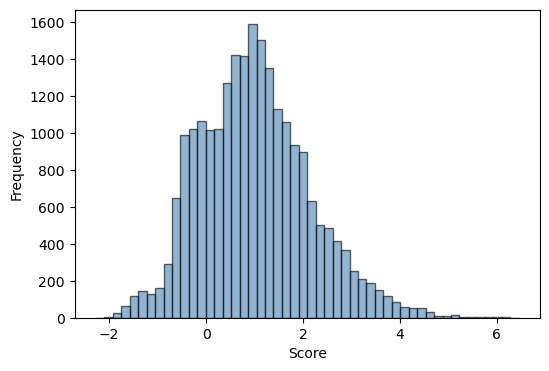

In [288]:
x_train['scores'] = score_function(w.values, x_train[best_attrs])
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(x_train['scores'], bins = 50, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black")
labs = ax.set(xlabel = r"Score", ylabel = "Frequency") 

Most of the scores fall between 0 and 2. This gives us an idea for where the threshold may fall as well.

We can now define the benefit function. We are going to stick with the function given in the assignment, because I do not know much about bank profits!

In [289]:
def get_benefit(loan_amt, loan_int_rate, default):
    loan_int_rate = loan_int_rate/100
    if default == False:
        cost = loan_amt*(1 + 0.25*loan_int_rate)**10 - loan_amt
    else:
        cost = loan_amt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amt
    return cost

Next, I added a column into the dataset for c (profit for someone who doesn't default) and C (profit for someone who defaults). This helps me to be able to filter more easily in the future! I made sure to apply the function to the whole pandas series for each column, since Pandas can handle vector arithmetic.

In [290]:
x_train['c'] = get_benefit(x_train["loan_amnt"], x_train["loan_int_rate"], False)
x_train['C'] = get_benefit(x_train["loan_amnt"], x_train["loan_int_rate"], True)
x_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,scores,c,C
1,27,98000,3.0,11750,13.47,0.12,6,False,False,False,...,True,False,False,False,False,False,True,1.201226,4613.567568,-6997.533847
2,22,36996,5.0,10000,7.51,0.27,4,False,False,False,...,False,False,False,False,False,True,False,2.404884,2044.334031,-6426.108799
3,24,26000,2.0,1325,12.87,0.05,4,False,False,False,...,True,False,False,False,False,True,False,0.640802,493.650464,-795.445199
4,29,53004,2.0,15000,9.63,0.28,10,True,False,False,...,False,False,False,False,False,True,False,1.5449,4028.690420,-9390.333437
6,21,21700,2.0,5500,14.91,0.25,2,False,False,False,...,False,True,False,False,False,True,False,2.297004,2430.522429,-3211.752128


Now for the actual calculations! Below, we loop through 101 possible threshold values and find the benefit for each one. We maintain an array of thresholds and an array of benefits for easy plotting.

Text(0, 0.5, 'Total benefit in dollars')

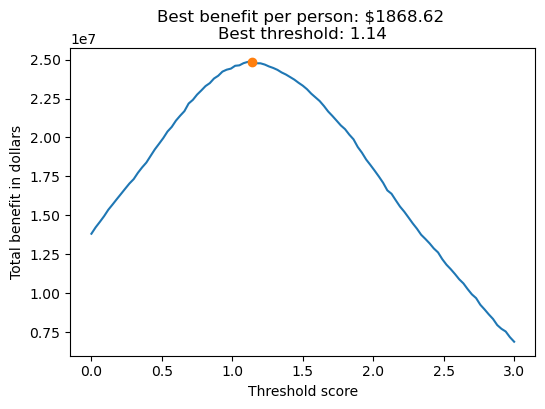

In [308]:
best_benefit = 0
best_threshold = 0
t_arr = []
benefits = []
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(0, 3, 101): 
    y_pred = x_train['scores'] >= t
    tn = ((y_pred == 0) & (y_train == 0)).mean()
    fn = ((y_pred == 0) & (y_train == 1)).mean()
    benefit = x_train['c'][x_train['scores'] >= t].sum()*tn - x_train['C'][x_train['scores'] >= t].sum()*fn
    t_arr.append(t)
    benefits.append(benefit)
    if benefit > best_benefit: 
        best_benefit = benefit
        best_threshold = t

plt.plot(t_arr, benefits)
plt.plot(best_threshold, best_benefit, marker="o")
plt.title(f"Best benefit per person: ${(best_benefit/len(x_train[x_train["scores"] < best_threshold])).round(2)} \nBest threshold: {best_threshold}")
plt.xlabel("Threshold score")
plt.ylabel("Total benefit in dollars")

We have outputted this plot which shows us the curve of threshold plotted against benefit! We can also see that our best benefit per borrower is $1,868.62, and our optimal threshold is 1.14. Now, let's test this model and threshold against our testing data. Hopefully, since we did well with the cross-validation, we will do well on the yet unseen data.

### **Part E: Evaluate Your Model from the Bank’s Perspective**

In [292]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
x_test, y_test = prepare_data(df_test)
x_test['c'] = get_benefit(x_test["loan_amnt"], x_test["loan_int_rate"], False)
x_test['C'] = get_benefit(x_test["loan_amnt"], x_test["loan_int_rate"], True)

In [293]:
t = best_threshold

# compute the scores
x_test['scores'] = score_function(w.values, x_test[best_attrs])
preds = x_test['scores'] >= t

# compute error rates
FN = ((preds == 0) & (y_test == 1)).mean() 
TN = ((preds == 0) & (y_test == 0)).mean() 
# compute the expected gain
gain = x_test['c'][x_test['scores'] >= t].sum()*TN  - x_test['c'][x_test['scores'] >= t].sum()*FN
gain/len(x_test[x_test["scores"] < t])

np.float64(1361.3320954051185)

Our profit per borrower is $1,361.33. Not as much as in our training data, but not bad!

### **Part F: Evaluate Your Model From the Borrower’s Perspective**
##### 1. Is it more difficult for people in certain age groups to access credit under your proposed system?
Let's look at a plot and find out.

Text(0.5, 1.0, 'Scores against age for prospective borrowers')

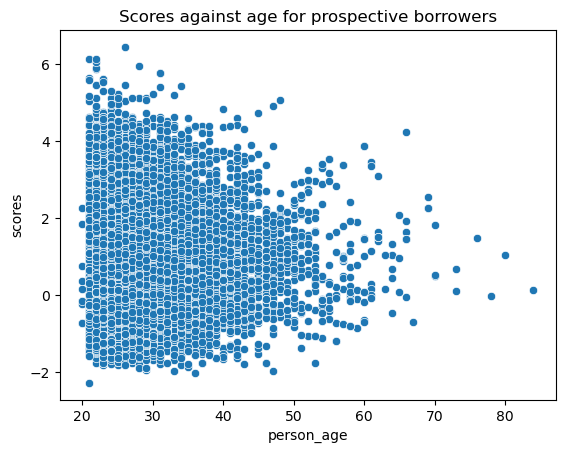

In [294]:
plot = sns.scatterplot(x_train[x_train["person_age"] < 100], x = "person_age", y = "scores")
plot.set_title("Scores against age for prospective borrowers")

It doesn't look like there is much correlation between score and age. 

##### Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?

Let's check out the data:

In [295]:
df_train["scores"] = x_train["scores"]
df_train.groupby("loan_intent")["scores"].max()

loan_intent
DEBTCONSOLIDATION     6.14476
EDUCATION            6.449154
HOMEIMPROVEMENT       6.06195
MEDICAL              5.965717
PERSONAL             6.137947
VENTURE               5.89633
Name: scores, dtype: object

So the maximum score for medical is lower than almost all the other maximum scores. However, this may not reflect the average score given to medical borrowers.

In [296]:
df_train.groupby("loan_intent")["scores"].mean()

loan_intent
DEBTCONSOLIDATION    1.114447
EDUCATION             1.00498
HOMEIMPROVEMENT      0.873225
MEDICAL              1.100077
PERSONAL             0.969918
VENTURE              0.900046
Name: scores, dtype: object

Here, we can see that the average score for a medical loan request is actually higher than many of the other categories.  In general, the Venture category has a low score for both the max score and the mean score. Debt consolidation tends to score hgih, as does education. Medical flips from the high end (mean) to the low end (max). We can also look at the count of each that got a loan, as opposed to the true default values.

In [297]:
df_train[df_train["scores"] >= best_threshold].groupby("loan_intent").size() - df_train[df_train["scores"] >= best_threshold][df_train["loan_status"] == 0].groupby("loan_intent").size()

/var/folders/sy/9tmrg3gx65vf4qjw8jl8ytsc0000gn/T/ipykernel_82223/2869003493.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train[df_train["scores"] >= best_threshold].groupby("loan_intent").size() - df_train[df_train["scores"] >= best_threshold][df_train["loan_status"] == 0].groupby("loan_intent").size()


loan_intent
DEBTCONSOLIDATION    648
EDUCATION            574
HOMEIMPROVEMENT      424
MEDICAL              718
PERSONAL             534
VENTURE              468
dtype: int64

Here, we calculated the number of people in each loan intent group that were above the threshold and defaulted. Overall, it seems like the error rate among groups was pretty equal when you consider the size of the groups.

##### How does a person’s income level impact the ease with which they can access credit under your decision system?

<Axes: xlabel='person_income', ylabel='scores'>

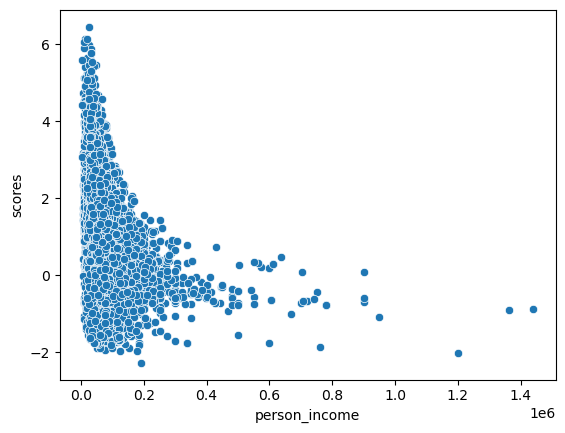

In [298]:
sns.scatterplot(x = x_train[x_train["person_income"] < 2000000]["person_income"], y = x_train["scores"])

Overall, it seems like lower-income people are more likely to receive a higher score. This is interesting to me because I would assume those who are higher income would be more likely to pay off their loans. However, maybe interest rates are higher among lower-income people in this dataset. Also, it could have something to do with the reasons people are requesting loans.

### **Part G: Write and Reflect**
##### Considering that people seeking loans for medical expense have high rates of default, is it fair that it is more difficult for them to obtain access to credit?

I think this depends on whether you are thinking from a utilitarian or ethical view of fairness. I also think that fairness is not necessary always ethical in the ways people use it. I believe that it is unfair that people who need help cannot access it, and I think it is sad that profits are often prioritized over people.

My definition of fairness: Equity--people who need help get it.

However, I can see how someone would argue that while it is unethical to deny someone a medical loan, it may still be fair. Basing loans off of likelihood of default is an objective way of making the decision, and I think some people see objectivity as fairness.

### **Discussion**

After completing this blog post, I had a lot more thoughts about using machine learning to predict human behavior. The first assignment was cool because we could get such high accuracy, but this one (and the in-class examples) made me wonder more about ethics. Predicting human behavior is inherently harder for algorithms, and the consequences of getting it wrong are higher. I generally think that using machine learning in situations like this is tempting, but seems very dangerous. The added probability of being wrong and the added consequences of being wrong generally make for a bad risk management decision. In terms of this case, people who needed money and would have paid on time may get passed over because of an algorithmically generated score.